In [2]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
bene = pd.read_csv('./data/Train_Beneficiary.csv')
inpat = pd.read_csv('./data/Train_Inpatient.csv')
outpat = pd.read_csv('./data/Train_Outpatient.csv')
target = pd.read_csv('./data/Train.csv')

print(bene.shape)
print(inpat.shape)
print(outpat.shape)
print(target.shape)

(138556, 25)
(40474, 30)
(517737, 27)
(5410, 2)


In [4]:
bene = bene.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 0)
bene = bene.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})

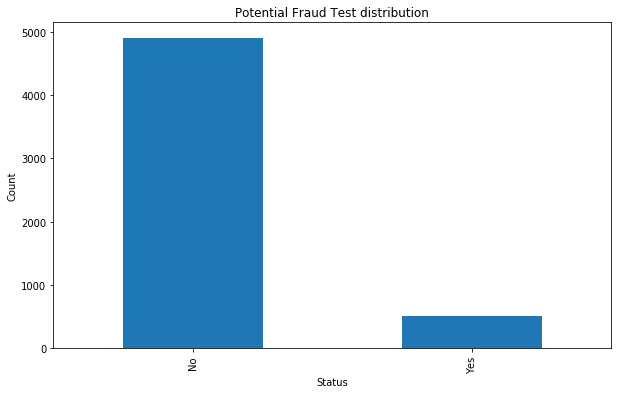

In [5]:
plt.title("Potential Fraud Test distribution")
target.groupby( ["PotentialFraud"] ).Provider.count().plot(kind = "bar", figsize = (10,6))
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

Change label to binary for fraud target

In [6]:
target["target"] = np.where(target.PotentialFraud == "Yes", 1, 0) 


Add Features to flag if patient is dead


In [7]:
bene['WhetherDead']= 0
bene.loc[bene.DOD.notna(),'WhetherDead'] = 1

Create Flag Before merge to track whats inpatient and whats outpatient

In [8]:
inpat['Status'] = 'in'
outpat['Status'] = 'out'

Combine inpatient and outpatient data

In [9]:
mediCare = pd.merge(inpat, outpat, left_on = [ x for x in outpat.columns if x in inpat.columns], right_on = [ x for x in outpat.columns if x in inpat.columns], how = 'outer')
mediCare.shape

(558211, 31)

Combine with beneficiary. (Outer join to preserve all records)

In [10]:
data = pd.merge(mediCare, bene,left_on='BeneID',right_on='BeneID',how='inner')
data.shape

(558211, 56)

In [11]:
data.sample(3)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,WhetherDead
488946,BENE133009,CLM456966,2009-07-07,2009-07-07,PRV54342,200,PHY353365,NaN,NaN,NaN,...,0,0,0,0,0,0,0,440,70,0
370551,BENE88394,CLM161667,2009-01-27,2009-01-27,PRV55933,20,PHY396282,NaN,PHY342509,NaN,...,1,1,0,0,0,0,0,140,100,0
363477,BENE85654,CLM188532,2009-02-11,2009-02-11,PRV51017,30,PHY345144,NaN,PHY433895,NaN,...,1,0,0,0,0,0,0,400,100,0


Count number of Procedures in the claim


In [12]:
ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]

In [13]:
data['NumProc'] = data[ClmProcedure_vars].notnull().to_numpy().sum(axis = 1)

In [14]:
np.unique(data.NumProc.values)

array([0, 1, 2, 3, 4, 5])

Count number of diagnoses per claim

In [16]:
ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]
    
### Create new variable 
data['NumClaims'] = data[ClmDiagnosisCode_vars].notnull().to_numpy().sum(axis = 1)


In [17]:
np.unique(data.NumClaims.values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [15]:
data.dtypes

BeneID                              object
ClaimID                             object
ClaimStartDt                        object
ClaimEndDt                          object
Provider                            object
InscClaimAmtReimbursed               int64
AttendingPhysician                  object
OperatingPhysician                  object
OtherPhysician                      object
AdmissionDt                         object
ClmAdmitDiagnosisCode               object
DeductibleAmtPaid                  float64
DischargeDt                         object
DiagnosisGroupCode                  object
ClmDiagnosisCode_1                  object
ClmDiagnosisCode_2                  object
ClmDiagnosisCode_3                  object
ClmDiagnosisCode_4                  object
ClmDiagnosisCode_5                  object
ClmDiagnosisCode_6                  object
ClmDiagnosisCode_7                  object
ClmDiagnosisCode_8                  object
ClmDiagnosisCode_9                  object
ClmDiagnosi

In [18]:
from datetime import datetime

In [19]:
data['AdmissionDt'] = pd.to_datetime(data['AdmissionDt'] , format = '%Y-%m-%d')
data['DischargeDt'] = pd.to_datetime(data['DischargeDt'],format = '%Y-%m-%d')

data['ClaimStartDt'] = pd.to_datetime(data['ClaimStartDt'] , format = '%Y-%m-%d')
data['ClaimEndDt'] = pd.to_datetime(data['ClaimEndDt'],format = '%Y-%m-%d')

data['DOB'] = pd.to_datetime(data['DOB'] , format = '%Y-%m-%d')
data['DOD'] = pd.to_datetime(data['DOD'],format = '%Y-%m-%d')

### Number of hospitalization days
data['AdmissionDays'] = ((data['DischargeDt'] - data['AdmissionDt']).dt.days) + 1
### Number of claim days 
data['ClaimDays'] = ((data['ClaimEndDt'] - data['ClaimStartDt']).dt.days) + 1

data['Age'] = round(((data['ClaimStartDt'] - data['DOB']).dt.days + 1)/365.25)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [20]:
mean_reim = data.groupby('Age')['InscClaimAmtReimbursed'].mean().reset_index()
median_reim = data.groupby('Age')['InscClaimAmtReimbursed'].median().reset_index()

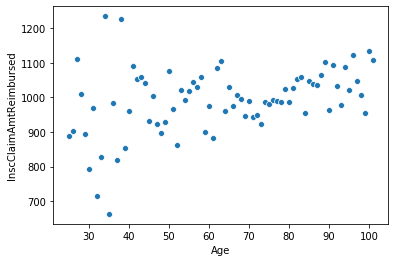

In [21]:
ax = sns.scatterplot(x='Age',y='InscClaimAmtReimbursed', data=mean_reim)
ax.figure.savefig("./plots/age_v_meanReim.svg",bbox_inches='tight')

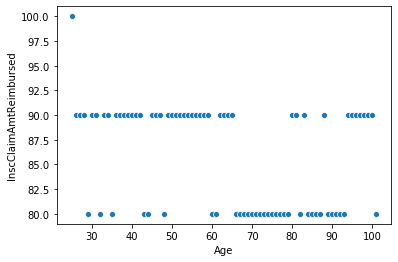

In [29]:
ax = sns.scatterplot(x='Age',y='InscClaimAmtReimbursed', data=median_reim)
ax.figure.savefig("./plots/age_v_medReim.svg",bbox_inches='tight')

In [73]:
for i in np.unique(data.State):
    state_data = data[data.State==i]
    filename = "./plots/state_level/age-claim/state_{}.png".format(i)
    print(filename)
    plt.figure()
    ax = sns.scatterplot(x='Age',y='InscClaimAmtReimbursed', hue = 'Status', data=state_data);
    ax.figure.savefig(filename,bbox_inches='tight');
    plt.close()



./plots/state_level/age-claim/state_1.png
./plots/state_level/age-claim/state_2.png
./plots/state_level/age-claim/state_3.png
./plots/state_level/age-claim/state_4.png
./plots/state_level/age-claim/state_5.png
./plots/state_level/age-claim/state_6.png
./plots/state_level/age-claim/state_7.png
./plots/state_level/age-claim/state_8.png
./plots/state_level/age-claim/state_9.png
./plots/state_level/age-claim/state_10.png
./plots/state_level/age-claim/state_11.png
./plots/state_level/age-claim/state_12.png
./plots/state_level/age-claim/state_13.png
./plots/state_level/age-claim/state_14.png
./plots/state_level/age-claim/state_15.png
./plots/state_level/age-claim/state_16.png
./plots/state_level/age-claim/state_17.png
./plots/state_level/age-claim/state_18.png
./plots/state_level/age-claim/state_19.png
./plots/state_level/age-claim/state_20.png
./plots/state_level/age-claim/state_21.png
./plots/state_level/age-claim/state_22.png
./plots/state_level/age-claim/state_23.png
./plots/state_level/

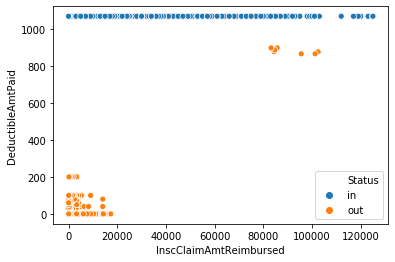

In [23]:
sns.scatterplot(x='InscClaimAmtReimbursed',
                y='DeductibleAmtPaid',
                hue='Status',
                data=data)

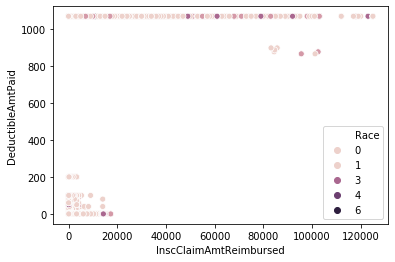

In [24]:
sns.scatterplot(x='InscClaimAmtReimbursed',
                y='DeductibleAmtPaid',
                hue='Race',
                data=data)

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


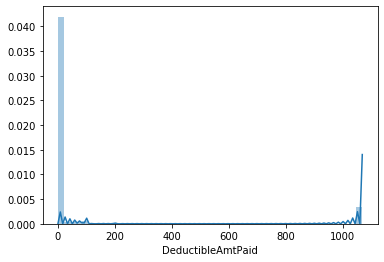

In [22]:
sns.distplot(data.DeductibleAmtPaid)

In [26]:
np.unique(data.Race.values)

array([1, 2, 3, 5])

In [35]:
data[ClmDiagnosisCode_vars].sample(19)

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10
360707,NaN,24920,V0481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349478,NaN,52871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438937,7823,V184,53081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98072,99673,99661,V1254,25040,28521,42731,5856,5855,99889,2859,NaN
182898,NaN,V6759,V5869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408013,NaN,5880,40390,4011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
554029,NaN,V8712,311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63698,71946,72660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177517,42731,3950,33394,4281,4928,78079,NaN,NaN,NaN,NaN,NaN
400427,NaN,V470,72887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i in np.unique(data.State):
    state_data = data[data.State==i]
    filename = "./plots/state_level/age-claim/state_{}.png".format(i)
    print(filename)
    plt.figure()
    ax = sns.scatterplot(x='Age',y='InscClaimAmtReimbursed', hue = 'Status', data=state_data);
    ax.figure.savefig(filename,bbox_inches='tight');
    plt.close()


In [ ]:
data.groupby('Race').